In [1]:
import requests
import pandas as pd
import time
import seaborn as sns


In [2]:
def ingame(pseudo_live, rgn, RAPI):
    #Récupération des information du joueur pseudo_test
    pseudo_live_link = "https://{}.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}".format(rgn, pseudo_live, RAPI)
    pseudo_live = requests.get(pseudo_live_link).json()

    print("Game de: ", pseudo_live['name'], "\n")

    #Récupération de la game en cours
    live_match_link = "https://{}.api.riotgames.com/lol/spectator/v4/active-games/by-summoner/{}?api_key={}".format(rgn, pseudo_live['id'], RAPI)
    live_match = requests.get(live_match_link).json()

    players_ingame = []
    #Si le joueur pseudo_test n'est pas en game print, sinon check le mode de jeu puis boucle sur tout les joueurs de la game
    if 'status' in live_match.keys():
        print("Player is not in game")
    elif live_match['gameMode'] == "CLASSIC":
        for player_row in live_match['participants']:
            player = {}
            player['pseudo'] = player_row['summonerName']
            player_rank = requests.get("https://{}.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}".format(rgn, player_row['summonerId'], RAPI)).json()
            if len(player_rank) == 0:
                player['rank'] = "unranked"
            elif player_rank[0]['queueType'] == "RANKED_SOLO_5x5":
                player['rank'] = player_rank[0]['tier'] + " " + player_rank[0]['rank']
            else:
                player['rank'] = player_rank[1]['tier'] + " " + player_rank[1]['rank']
            player['champion'] = champion_id[player_row['championId']]
            player['spell1'] = spell_id[player_row['spell1Id']]
            player['spell2'] = spell_id[player_row['spell2Id']]
            if player_row['teamId'] == 100:
                player['team'] = "blue"
            else:
                player['team'] = "red"
            players_ingame.append(player)
    elif live_match['gameMode'] == "ARAM":
        for player_row in live_match['participants']:
            player = {}
            player['pseudo'] = player_row['summonerName']
            player_mmr = requests.get("https://euw.whatismymmr.com/api/v1/summoner?name={}".format(player_row['summonerName'])).json()
            if 'error' in player_mmr.keys():
                player['mmr'] = "N/A"
            else:
                player['mmr'] = str(player_mmr['ARAM']['avg']) + " +- " + str(player_mmr['ARAM']['err'])
            player_rank = requests.get("https://{}.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}".format(rgn, player_row['summonerId'], RAPI)).json()
            if not player_rank:
                player['rank'] = "unranked"
            else:
                for i in range(len(player_rank)):
                    if player_rank[i]['queueType'] == "RANKED_SOLO_5x5":
                        player['rank'] = player_rank[i]['tier'] + " " + player_rank[i]['rank']
            player['champion'] = champion_id[player_row['championId']]
            player['spell1'] = spell_id[player_row['spell1Id']]
            player['spell2'] = spell_id[player_row['spell2Id']]
            if player_row['teamId'] == 100:
                player['team'] = "blue"
            else:
                player['team'] = "red"
            players_ingame.append(player)

    #Dataframe
    df = pd.DataFrame(players_ingame)
    return df


In [3]:
def create_dict_cleaned(player:dict, list_champs:list,current_dict={}) -> dict:
    for champ in list_champs:
        if champ in player:
            current_dict[champ] = player[champ]
        else:
            current_dict[champ] = None
    return current_dict


In [4]:
def getStats(pseudo, rgn, RAPI, region, start_game, nb_game):
    timeout = 0
    i = 0
    j = 0
    matches = []
    matches_array=[]
    
    #Récupération des informations du joueur pseudo
    pseudo_link = "https://{}.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}".format(rgn, pseudo, RAPI)
    pseudo_json = requests.get(pseudo_link).json()
    print ("Historique de:", pseudo_json['name'])

    #Boucle pour récupérerun maximum de 300 games dans mon historique
    while start_game < 300:
        matches_link = "https://{}.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?api_key={}&start={}&count={}".format(region, pseudo_json['puuid'], RAPI, start_game, nb_game)
        matches += requests.get(matches_link).json()
        start_game += nb_game

    print("Nombre de games à analyser:", len(matches))
    if len(matches) >= 83 :
        time.sleep(120)

    #Boucle sur chaque id de game pour avoir les details de chaque game
    for match in matches:
        match_detail_link = "https://{}.api.riotgames.com/lol/match/v5/matches/{}?api_key={}".format(region, match, RAPI)
        match_detail = requests.get(match_detail_link).json()
        #print("game numéro:", i, " link:", match_detail_link)

        #Récuperation des données uniquement des games d'ARAM
        if match_detail['info']['gameMode'] == "ARAM":
            players = []
            for player_row in match_detail['info']['participants']:
                #Correspondance du pseuso, pour sortir les données uniquement du joueur recherché
                if player_row['summonerName'] == pseudo_json['name']:
                    player = {}
                    list_champs = ["championName", "summoner1Id", "summoner2Id", "kills", "deaths", "assists", "totalMinionsKilled", "item0", "item1", "item2", "item3", "item4", "item5", "item6", "goldEarned", "totalDamageDealtToChampions", "physicalDamageDealtToChampions", "magicDamageDealtToChampions", "trueDamageDealtToChampions", "totalDamageTaken", "physicalDamageTaken", "magicDamageTaken", "trueDamageTaken", "damageDealtToObjectives", "damageSelfMitigated", "totalHeal", "totalHealsOnTeammates", "firstBloodKill", "doubleKills", "tripleKills", "quadraKills", "pentaKills", "largestKillingSpree", "turretsLost", "turretTakedowns", "teamId", "win", "gameEndedInEarlySurrender", "gameEndedInSurrender"]
                    list_champs_challenges = ["kda", "killParticipation", "goldPerMinute", "damagePerMinute", "teamDamagePercentage", "damageTakenOnTeamPercentage", "killsNearEnemyTurret", "killsUnderOwnTurret", "takedownsInEnemyFountain", "killsOnRecentlyHealedByAramPack", "firstTurretKilledTime"]
                    player = create_dict_cleaned(player_row, list_champs,player)
                    if "challenges" in player_row:
                        player = create_dict_cleaned(player_row["challenges"], list_champs_challenges,player)

                    players.append(player)

            df_players = pd.DataFrame(players)
            matches_array.append(df_players)
            
        i+=1
        timeout += 1
        #Donne du souffle à l'API
        if timeout >= 100 and i != len(matches):
            j+=1
            #print("timeouted:", j, " quand i vaut:", i)
            timeout = 0
            time.sleep(120)

    #Concatenation des games une à une, dans un grand Dataframe
    if len(matches_array) != 0:
        df = pd.concat(matches_array)
        df
        df.to_csv("rawData.csv", index=False)
        return df
    else:
        return "Pas de game d'ARAM"


In [5]:
#Variables
pseudo = "jsob"
pseudo_live = "opossos"
RAPI = 'RGAPI-da4a4fec-74ce-430d-981f-52dd4f813b82'
rgn = 'euw1'
region = "europe"
start_game = 0
nb_game = 20

#Correspondance id_ spell/champion
spell_id = {21: "Barrier", 1: "Cleanse", 14: "Ignite", 3: "Exhaust", 4: "Flash", 6: "Ghost", 7: "Heal", 13: "Clarity", 30: "To the King!", 31: "Poro Toss", 11: "Smite", 39: "Mark", 32: "Mark", 12: "Teleport", 54: "Placeholder", 55: "Placeholder and Attack-Smite"}
champion_id = {266: "Aatrox", 103: "Ahri", 84: "Akali", 166: "Akshan", 12: "Alistar", 32: "Amumu", 34: "Anivia", 1: "Annie", 523: "Aphelios", 22: "Ashe", 136: "Aurelion Sol", 268: "Azir", 432: "Bard", 53: "Blitzcrank", 63: "Brand", 201: "Braum", 51: "Caitlyn", 164: "Camille", 69: "Cassiopeia", 31: "Cho Gath", 42: "Corki", 122: "Darius", 131: "Diana", 119: "Draven", 36: "Dr. Mundo", 245: "Ekko", 60: "Elise", 28: "Evelynn", 81: "Ezreal", 9: "Fiddlesticks", 114: "Fiora", 105: "Fizz", 3: "Galio", 41: "Gangplank", 86: "Garen", 150: "Gnar", 79: "Gragas", 104: "Graves", 887: "Gwen", 120: "Hecarim", 74: "Heimerdinger", 420: "Illaoi", 39: "Irelia", 427: "Ivern", 40: "Janna", 59: "Jarvan IV", 24: "Jax", 126: "Jayce", 202: "Jhin", 222: "Jinx", 145: "Kai Sa", 429: "Kalista", 43: "Karma", 30: "Karthus", 38: "Kassadin", 55: "Katarina", 10: "Kayle", 141: "Kayn", 85: "Kennen", 121: "Kha Zix", 203: "Kindred", 240: "Kled", 96: "Kog Maw", 7: "LeBlanc", 64: "Lee Sin", 89: "Leona", 876: "Lillia", 127: "Lissandra", 236: "Lucian", 117: "Lulu", 99: "Lux", 54: "Malphite", 90: "Malzahar", 57: "Maokai", 11: "Master Yi", 21: "Miss Fortune", 62: "Wukong", 82: "Mordekaiser", 25: "Morgana", 267: "Nami", 75: "Nasus", 111: "Nautilus", 518: "Neeko", 76: "Nidalee", 56: "Nocturne", 20: "Nunu & Willump", 2: "Olaf", 61: "Orianna", 516: "Ornn", 80: "Pantheon", 78: "Poppy", 555: "Pyke", 246: "Qiyana", 133: "Quinn", 497: "Rakan", 33: "Rammus", 421: "Rek Sai", 526: "Rell", 888: "Renata Glasc", 58: "Renekton", 107: "Rengar", 92: "Riven", 68: "Rumble", 13: "Ryze", 360: "Samira", 113: "Sejuani", 235: "Senna", 147: "Seraphine", 875: "Sett", 35: "Shaco", 98: "Shen", 102: "Shyvana", 27: "Singed", 14: "Sion", 15: "Sivir", 72: "Skarner", 37: "Sona", 16: "Soraka", 50: "Swain", 517: "Sylas", 134: "Syndra", 223: "Tahm Kench", 163: "Taliyah", 91: "Talon", 44: "Taric", 17: "Teemo", 412: "Thresh", 18: "Tristana", 48: "Trundle", 23: "Tryndamere", 4: "Twisted Fate", 29: "Twitch", 77: "Udyr", 6: "Urgot", 110: "Varus", 67: "Vayne", 45: "Veigar", 161: "Vel Koz", 711: "Vex", 254: "Vi", 234: "Viego", 112: "Viktor", 8: "Vladimir", 106: "Volibear", 19: "Warwick", 498: "Xayah", 101: "Xerath", 5: "Xin Zhao", 157: "Yasuo", 777: "Yone", 83: "Yorick", 350: "Yuumi", 154: "Zac", 238: "Zed", 221: "Zeri", 115: "Ziggs", 26: "Zilean", 142: "Zoe", 143: "Zyra"}
champions_info = "https://ddragon.leagueoflegends.com/cdn/12.8.1/data/en_US/champion.json"
summonerSpell_info ="https://ddragon.leagueoflegends.com/cdn/12.8.1/data/en_US/summoner.json"
item_info = "https://ddragon.leagueoflegends.com/cdn/12.8.1/data/en_US/item.json"


In [6]:
live = ingame(pseudo_live, rgn, RAPI)
df_live = pd.DataFrame(live)
df_live

Game de:  Opossos 



,pseudo,mmr,rank,champion,spell1,spell2,team
0,ICATHIAN RAlN,2901 +- 275,PLATINUM IV,Karma,Flash,Clarity,blue
1,Eiscreme,2961 +- 87,DIAMOND I,Renata Glasc,Flash,Exhaust,blue
2,Opossos,3044 +- 263,MASTER I,Gangplank,Flash,Mark,blue
3,Fabrikant Sebi,None +- 99,MASTER I,Kayle,Ghost,Flash,blue
4,LΣNNY,3169 +- 476,CHALLENGER I,Kalista,Flash,Exhaust,blue
5,Erijons,3229 +- 99,PLATINUM I,Nidalee,Flash,Mark,red
6,Prince of Lux,3135 +- 177,DIAMOND III,Samira,Mark,Flash,red
7,ƒearƒul,3083 +- 39,unranked,Zed,Flash,Mark,red
8,CH40T XerSai,3164 +- 45,NaN,Ashe,Exhaust,Flash,red
9,OOOAAAEEE,3194 +- 43,NaN,Akshan,Flash,Exhaust,red


In [8]:
stats = getStats(pseudo, rgn, RAPI, region, start_game, nb_game)
df_stats = pd.DataFrame(stats)
df_stats

In [10]:
rawData = pd.read_csv("C:/Users/SQL/Documents/cours/Projet Data/rawData.csv")
#rawData.head()
print("ok")

ok


In [11]:
groupByChampion = rawData.groupby(["championName"]).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print("groupByChampion: \n",groupByChampion)

groupByChampion: 
    championName  counts
45     Renekton      13
28      Leblanc       9
18         Gnar       7
50      Shyvana       6
35          Lux       6
..          ...     ...
42       Qiyana       1
43        Rakan       1
46      Sejuani       1
48         Sett       1
71         Zeri       1

[72 rows x 2 columns]


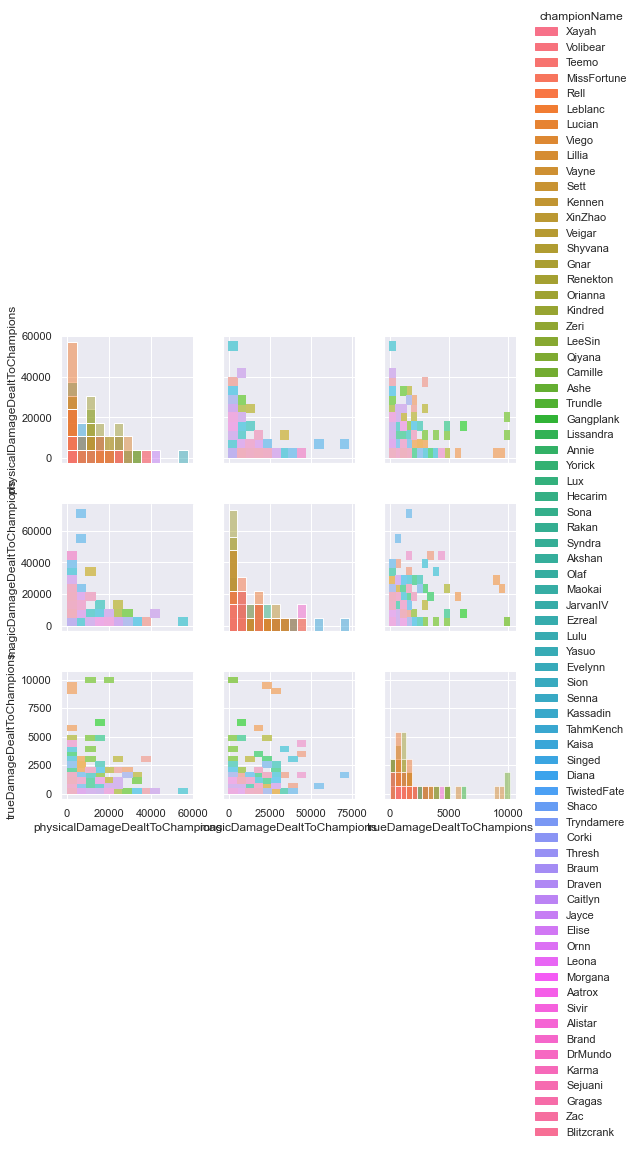

In [12]:
sns.set(rc={'figure.figsize':(12,10)})
sns.pairplot(rawData, vars=["physicalDamageDealtToChampions", "magicDamageDealtToChampions", "trueDamageDealtToChampions"], hue="championName", kind="hist")

In [13]:
print("ok")

ok
